In [2]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as tt
import pymc3 as pm
import scipy.stats
import arviz as az
%matplotlib inline


theano.config.compute_test_value = 'ignore'
np.random.seed(2022)  

In [3]:
#%%
# ptsd_scr.csv is a csv file from Homan et al.'s work where filepath is ./preproc_NotInMakefile/scr/ptsd_scr.csv
# obtain stimuli order from Homan et al.'s work
df = pd.read_csv("ptsd_scr.csv")
orderA = list(df.loc[df["id"]=="RV001"]["stim"])

def order_to_stim_and_shock(order):
    '''
    convert stimuli order from Homan et al.'s work to format that can be used in RW model

    returns:
    stim(list of int with size (69)): pseudorandomized order that stimuli were presented (1 = faceA present at that trial, 0 = faceB present at that trial)
    shock(list of int with size (69)): order that the shock were presented (0 = shock absent, 1 = shock present)
    '''
    stim = []
    shock = []
    for i in orderA:
        if i == "CSplusUS":
            # 1 = cs+ (aka face A)
            stim.append(1)
            # 1 for shock present
            shock.append(1)
        elif (i == "CSminusUS"):
            # 0 = cs- (aka face B)
            stim.append(0)
            # 1 for shock present
            shock.append(1)
        elif (i == "CSplus"):
            # 1 = cs+ (aka face A)
            stim.append(1)
            # 0 for shock absent
            shock.append(0)
        else:
            # 0 = cs- (aka face B)
            stim.append(0)
            # 0 for shock absent
            shock.append(0)
    stim = np.array(stim,dtype=np.int64)
    shock = np.array(shock,dtype=np.int64)
    
    return stim, shock

def separate_combined_v(combined_v,order):
    '''
    separate the series of expected values into two lists according the type of stimuli (only include trials without shock)

    returns:
    v_stim_A(list of float): expected values of trials where face A was presented (without shock trial)
    v_stim_B(list of float): expected values of trials where face B was presented (without shock trial)
    '''
    v_stim_A = []
    v_stim_B = []
    for i in np.arange(len(orderA)):
        if (orderA[i] == "CSplus"):
            v_stim_A.append(combined_v[i])
        elif (orderA[i] == "CSminus"):
            v_stim_B.append(combined_v[i])
        elif (orderA[i] == "CSplusUS"):
            v_stim_A.append(combined_v[i])
        elif (orderA[i] == "CSminusUS"):
            v_stim_B.append(combined_v[i])
    
    return v_stim_A, v_stim_B


In [4]:
def simulate_Rescorla_Wagner(theta0,theta1,epsilon,lr,stim,shock):
    """ Simulate the Rescorla-Wagner model
    params:
        theta0(float): constant term for SCR mapping
        theta1(float): scale value for SCR mapping
        epsilon(float): error term for SCR mapping
        lr(float): learning rate of RW model which is between 0 to 1
        stim(list of int with size (69)): pseudorandomized order that stimuli were presented (1 = faceA present at that trial, 0 = faceB present at that trial)
        shock(list of int with size (69)): order that the shock were presented (0 = shock absent, 1 = shock present)
    returns:
        V(2d-list of float with size (2,69)): list containing list of expected value for each face
        mapped_scr(list of float with size (69)): a list of SCR reading which mapped from list of expected value of presented face
    """
    
    # store expected value of cs- and cs+ in [cs-,cs+] for each trials
    V_list = np.zeros((2, 69))
    # reflecting the assumption that getting a shock or not
    # was equally for the first trial
    V = [0.5, 0.5] 

    combined_v = []
    for t in range(69):

        # store expected value of trial t
        V_list[:,t] = V
        # update expected values
        prediction_error = shock[t] - V[stim[t]]
        V[stim[t]] = V[stim[t]] + lr * prediction_error
        combined_v.append(V[stim[t]])

    mapped_scr = theta0 + (theta1*np.array(combined_v)) + epsilon
    return V_list,mapped_scr

def update_RW(stim_matrix,shock_matrix,vS,combined_v,lr, no_subjects):
    """
    update function of Rescorla-Wagner model, which will be used in pymc3 model fitting
    
    returns:
    vS: list of [[v_list for CS-, v_list for CS+],...] where shape = (no_subjects,2)
    combined_v: a series of expected value by combining expected value of face A and face B in the order of the appearance of cue
    """
    pe = shock_matrix - vS[tt.arange(no_subjects), stim_matrix]
    # vS is a list of [[v for CS-, v for CS+],...] where shape = (no_subjects,2)
    vS = tt.set_subtensor(vS[tt.arange(no_subjects),stim_matrix], vS[tt.arange(no_subjects),stim_matrix] + lr * pe)

    #if stim = 1, append v for cs+, else append v for cs-
    combined_v = tt.set_subtensor(combined_v[tt.arange(no_subjects),0], (tt.switch(tt.eq(stim_matrix,1), 
                                                                vS[tt.arange(no_subjects),1], vS[tt.arange(no_subjects),0])))

    return vS, combined_v


In [5]:
#######################################################
# code for the fitting and parameter recovery part
#######################################################

### create fake data ###
stim, shock = order_to_stim_and_shock(orderA)
#no of trials is fixed at 69 to correspond the experiment design
no_trials = 69
no_subjects = 60
mapped_scr_matrix = np.zeros(shape=(no_trials,no_subjects))

lr_ = np.random.uniform(low=0.0, high=1.0, size=no_subjects)
theta0_ = np.random.normal(loc=0.0, scale=1.0)
theta1_ = np.random.normal(loc=0.0, scale=1.0)
for i in range(no_subjects):
    epsilon = np.random.normal(loc=0.0, scale=0.05)
    v_list,mapped_scr = simulate_Rescorla_Wagner(theta0_,theta1_,epsilon,lr_[i],stim,shock)
    mapped_scr_matrix[:,i] = mapped_scr
    
# remove trial with shock from scr data to avoid contamination 
idx = [i for i in np.arange(len(shock)) if shock[i] == 1]
mapped_scr_matrix =  np.delete(mapped_scr_matrix, idx, axis=0)

In [6]:
### preparation for model fitting ###
# prepare stim matrix with shape = (no_trials,no_subjects) for feeding into the update_RW function
stim_ = stim.reshape(no_trials,1)
stim_matrix = np.repeat(stim_,no_subjects,axis=1)
stim_matrix = tt.as_tensor_variable(stim_matrix)

# prepare shock matrix with shape = (no_trials,no_subjects) for feeding into the update_RW function
shock_ = shock.reshape(no_trials,1)
shock_matrix = np.repeat(shock_,no_subjects,axis=1)
shock_matrix = tt.as_tensor_variable(shock_matrix)

# prepare index for row removal 
idx = [i for i in np.arange(len(shock)) if shock[i] != 1]

In [7]:
### hierarchical Bayesian model fitting ###
with pm.Model() as RW_model:
    ##############################################
    # free paramters from mapping eqution
    beta0 = pm.Normal('beta0',0,20)
    beta1 = pm.Normal('beta1',0,20)
    ##############################################
    # free parameter from learning equation
    
    # group-level mean and standard deviation of learning rate
    lr_hypermu = pm.Normal('lr_hypermu', 0,1)
    lr_hypersd = pm.HalfCauchy('lr_hypersd',beta=5)
    # individual learning rate is drawn from the group-level normal distribution
    lr_v = pm.Normal('lr_v',lr_hypermu,lr_hypersd,shape=no_subjects)
    # Convert unconstrained values into the interval [0,1] 
    # as the learning rate is bounded between 0 and 1
    lr = pm.Deterministic('lr', pm.math.invlogit(lr_v))
    ##############################################
    # step function
    vS = 0.5 * tt.ones((no_subjects,2), dtype='float64') 
    combined_v = 0.5 * tt.ones((no_subjects,1), dtype='float64') 

    outputs, updates = theano.scan(
        fn=update_RW,
        sequences=[stim_matrix, shock_matrix],
        outputs_info=[vS, combined_v],
        non_sequences=[lr, no_subjects])
    
    combined_v_ = outputs[1].reshape((no_trials,no_subjects))
    mapped_scr_model = beta1*combined_v_ + beta0
    
    #remove rows that represent shock to avoid contamination 
    mapped_scr_model = mapped_scr_model[idx]
    ##############################################
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=5,testval=1.0)
    
    # Data likelihood
    scrs = pm.Normal('scrs',mapped_scr_model,eps,observed=mapped_scr_matrix)
    
    ##############################################
    trace = pm.sample(1000,target_accept=0.9, chains=4,
                     cores=10, return_inferencedata=True)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 10 jobs)
NUTS: [eps, lr_v, lr_hypersd, lr_hypermu, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3286 seconds.


/var/folders/gx/bjzw6hpn029f930zwmrtgkn40000gn/T/ipykernel_95616/4255668653.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace)


array([[<AxesSubplot:title={'center':'beta0'}>,
        <AxesSubplot:title={'center':'beta0'}>],
       [<AxesSubplot:title={'center':'beta1'}>,
        <AxesSubplot:title={'center':'beta1'}>],
       [<AxesSubplot:title={'center':'lr_hypermu'}>,
        <AxesSubplot:title={'center':'lr_hypermu'}>],
       [<AxesSubplot:title={'center':'lr_v'}>,
        <AxesSubplot:title={'center':'lr_v'}>],
       [<AxesSubplot:title={'center':'lr_hypersd'}>,
        <AxesSubplot:title={'center':'lr_hypersd'}>],
       [<AxesSubplot:title={'center':'lr'}>,
        <AxesSubplot:title={'center':'lr'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

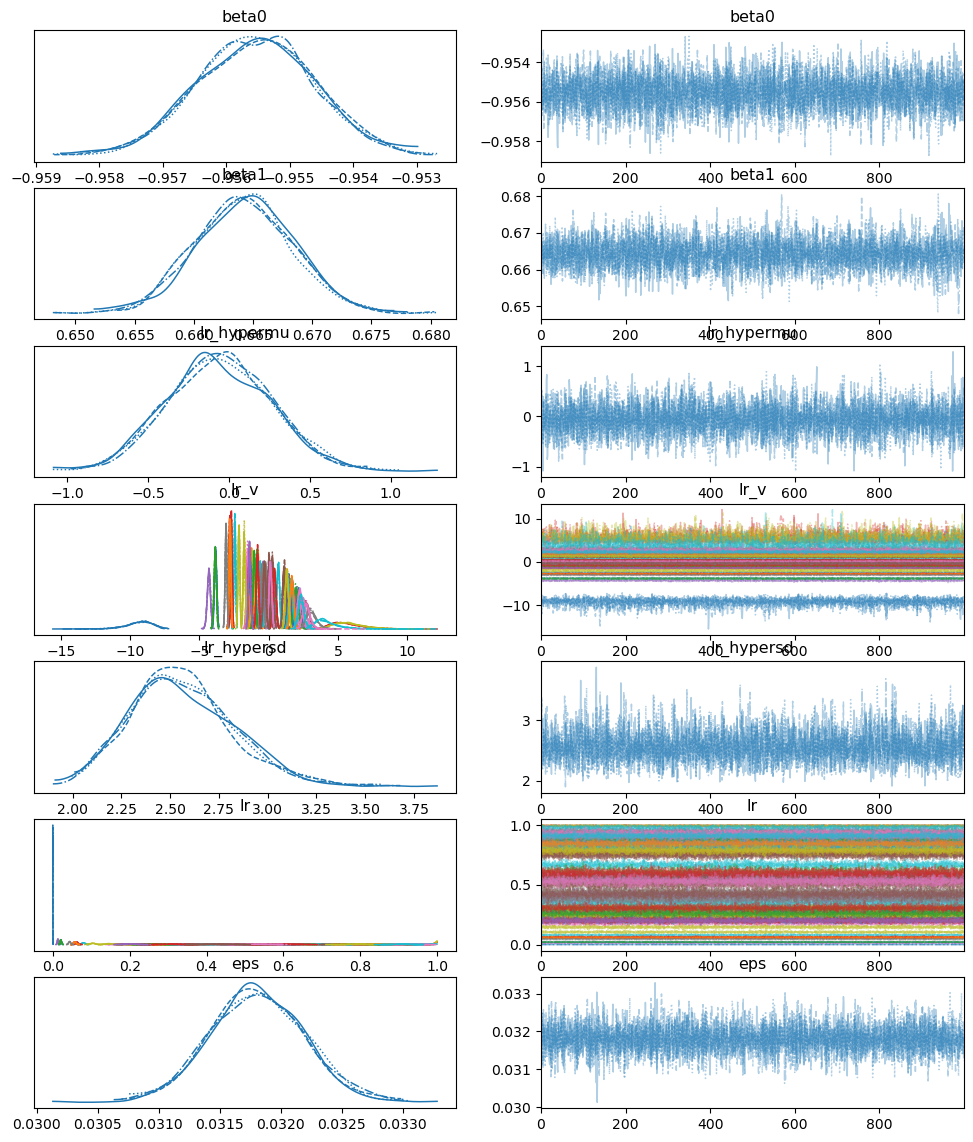

In [8]:
pm.traceplot(trace)

In [16]:
a = az.summary(trace,var_names='lr')['mean']
a.values

array([0.   , 0.266, 0.058, 0.057, 0.89 , 0.75 , 0.831, 0.441, 0.9  ,
       0.665, 0.812, 0.79 , 0.599, 0.994, 0.567, 0.563, 0.179, 0.528,
       0.995, 0.08 , 0.898, 0.314, 0.302, 0.601, 0.013, 0.936, 0.923,
       0.205, 0.104, 0.351, 0.252, 0.226, 0.877, 0.063, 0.843, 0.504,
       0.904, 0.955, 0.244, 0.981, 0.206, 0.058, 0.261, 0.199, 0.4  ,
       0.756, 0.529, 0.382, 0.146, 0.831, 0.021, 0.843, 0.021, 0.307,
       0.2  , 0.425, 0.938, 0.044, 0.786, 0.912])

In [11]:
lr_

array([0.00935861, 0.49905781, 0.11338369, 0.04997402, 0.68540759,
       0.48698807, 0.89765723, 0.64745207, 0.89696312, 0.72113493,
       0.83135342, 0.82756807, 0.83357958, 0.95704434, 0.36804444,
       0.49483763, 0.33950947, 0.61942933, 0.97752964, 0.09643308,
       0.74420621, 0.29249947, 0.29867535, 0.75247347, 0.01866373,
       0.52373744, 0.86443585, 0.38884284, 0.21219185, 0.4751807 ,
       0.56467242, 0.3494293 , 0.97590863, 0.03782004, 0.79426969,
       0.3578826 , 0.74796395, 0.91450931, 0.37266242, 0.96488347,
       0.08138577, 0.04245099, 0.29679603, 0.36370363, 0.49025518,
       0.66851874, 0.67341463, 0.57210064, 0.08059224, 0.89833126,
       0.03838853, 0.78219442, 0.03665636, 0.26718385, 0.20522385,
       0.25889443, 0.93261529, 0.00812491, 0.40347318, 0.89410221])

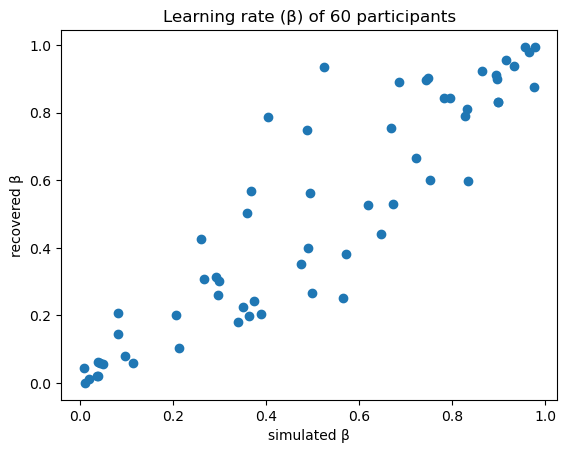

PearsonRResult(statistic=0.9113686138319637, pvalue=4.968479050026784e-24)

In [15]:
plt.title("Learning rate (\u03B2) of 60 participants")
plt.ylabel("recovered \u03B2")
plt.xlabel("simulated \u03B2")
plt.scatter(lr_,a.values)
plt.savefig("correlationPlot.png")
plt.show()
# std_error: 0.05 & no_subjects: 60 & std of lr_hypermu: 1

scipy.stats.pearsonr(lr_, a)

In [ ]:
# #################################################
# # code to produce figures for simulation section
# #################################################

stim, shock = order_to_stim_and_shock(orderA)
for i in [0,0.2,0.4,0.6,0.8,1]:
    theta0 = 0 #[-1,0,1]
    theta1 = 1 #[-1,0,1]
    lr = i #[0,0.2,0.4,0.6,0.8,1]
    epsilon = 0
    v_list,combined_v = simulate_Rescorla_Wagner(theta0,theta1,epsilon,lr,stim,shock)

    v_stim_A, v_stim_B = separate_combined_v(combined_v,orderA)
    plt.plot(range(len(v_stim_A)+1), [0.5]+v_stim_A, 'm-', alpha=.6, label='face A(shock in acquisition)')
    plt.plot(range(len(v_stim_B)+1), [0.5]+v_stim_B, 'r--', alpha=.6, label='face B(shock in reversal)')
    plt.xlabel('trials')
    plt.ylabel('expected value')
    plt.title('RW model ('+'\u03B2 = ' + str(lr) + ', \u03B8\u2080 = '+str(theta0)+ ', \u03B8\u2081 = '+str(theta1)+', \u03B5 = '+str(epsilon)+')')
    plt.legend()
    plt.ylim((0,1))
    # plt.savefig("RW_" + str(lr)+"_"+ str(theta0)+"_"+ str(theta1)+".png")
    plt.show()